In [1]:
import torch
#add modular_dnn to path
import sys
sys.path.append('/mnt/ssd-apollo/jake/rib/experiments/counterexamples')
from modular_dnn import BlockDiagonalDNN, RandomVectorDataset
from matplotlib import pyplot as plt
from rib.hook_manager import HookedModel, Hook
from torch.utils.data import DataLoader, Dataset
from rib.hook_fns import acts_pre_forward_hook_fn


In [2]:
from .modular_dnn import BlockDiagonalDNN, RandomVectorDataset

ImportError: attempted relative import with no known parent package

In [6]:
results = torch.load('/mnt/ssd-apollo/jake/rib/experiments/counterexamples/results/small_modular_dnn_seed179_n2_k2_layers3_random_act_identity_dsize_1000_bias0/rib_graph.pt')


In [7]:
results.keys()

dict_keys(['exp_name', 'gram_matrices', 'interaction_rotations', 'eigenvectors', 'rib_edges', 'neuron_edges', 'pca_edges', 'model_config_dict', 'mlp'])

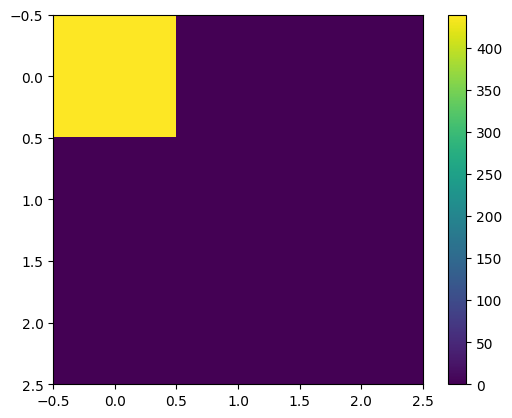

In [8]:
plt.imshow(results['rib_edges'][2][1])
plt.colorbar()

In [9]:
results['model_config_dict']

{'exp_name': 'small_modular_dnn',
 'n': 2,
 'k': 2,
 'layers': 3,
 'dataset_size': 1000,
 'batch_size': 32,
 'seed': 179,
 'truncation_threshold': 1e-30,
 'n_intervals': 0,
 'dtype': torch.float32,
 'node_layers': ['layers.0', 'layers.1', 'layers.2', 'layers.3', 'output'],
 'datatype': 'random',
 'rotate_final_node_layer': True,
 'force': True,
 'hardcode_bias': 0,
 'activation_fn': 'identity',
 'variances': None,
 'data_variances': None}

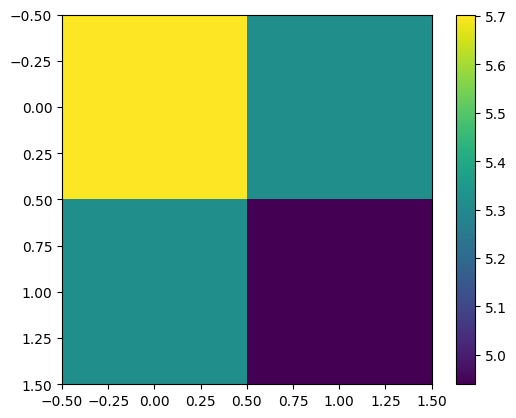

In [10]:
plt.imshow(results['gram_matrices']['output'].abs().log())
plt.colorbar()

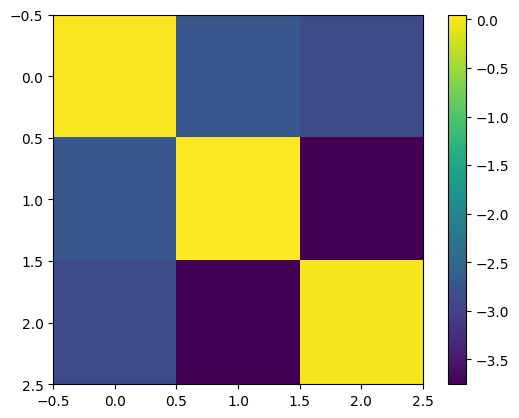

In [11]:
plt.imshow(results['gram_matrices']['layers.0'].abs().log())
plt.colorbar()

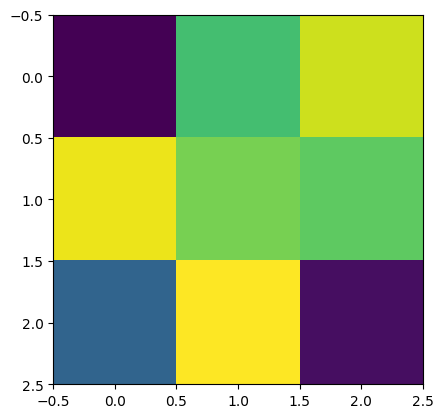

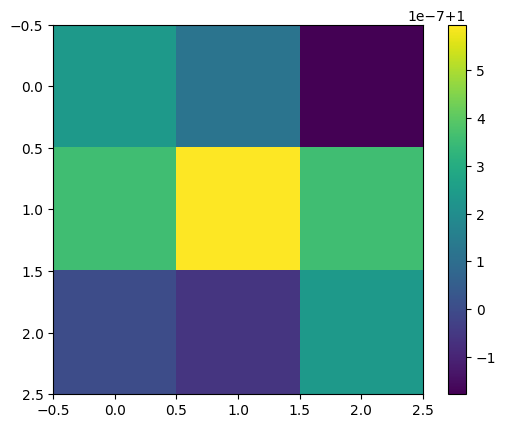

In [12]:
U,S,V = torch.svd(results['gram_matrices']['layers.0'])
plt.imshow(U)
plt.show()
plt.imshow(V/U)
plt.colorbar()

In [13]:
n = results['model_config_dict']['n']
k = results['model_config_dict']['k']
layers = results['model_config_dict']['layers']
mlp = BlockDiagonalDNN(layers = layers, n = n, k = k)
hooked_mlp = HookedModel(mlp)
mlp.load_state_dict(results['mlp'])
dataset = RandomVectorDataset(n, k, results['model_config_dict']['dataset_size'],results['model_config_dict']['data_variances'], dtype=results['model_config_dict']['dtype'])

dataloader = DataLoader(dataset, batch_size=results['model_config_dict']['dataset_size'], shuffle=True)

In [14]:
class OnesDataset(Dataset):
    def __init__(self, n):
        self.data = torch.ones(n)
        self.label = torch.tensor(1)

    def __len__(self):
        return 1  # Since there's only one datapoint

    def __getitem__(self, idx):
        return self.data, self.label

class IdentityDataset(Dataset):
    def __init__(self, n):
        self.data = torch.eye(n)
        self.label = torch.tensor(1)

    def __len__(self):
        return 1  # Since there's only one datapoint

    def __getitem__(self, idx):
        return self.data, self.label



# Create the dataset and dataloader
# dataset = OnesDataset(n)
# dataloader = DataLoader(dataset, batch_size=1)

In [15]:
n

2

In [16]:
dataset = IdentityDataset(n)
dataloader = DataLoader(dataset, batch_size=n)
for data,_ in dataloader:
    print(data) 
    print(mlp(data))
    print(hooked_mlp(data))
    break

tensor([[[1., 0.],
         [0., 1.]]])


RuntimeError: einsum(): subscript d has size 3 for operand 1 which does not broadcast with previously seen size 5

In [38]:
layers_to_hook = [f'layers.{i}' for i in range(4)]
activation_hooks = []
for layer in layers_to_hook:
    activation_hooks.append(
        Hook(
            name=layer, 
            data_key="activations", 
            fn=acts_pre_forward_hook_fn, 
            module_name=layer,
            fn_kwargs={}
        )
    )
for inputs, _ in dataloader:
    _ = hooked_mlp(inputs, hooks=activation_hooks)


RuntimeError: einsum(): subscript d has size 3 for operand 1 which does not broadcast with previously seen size 5

In [127]:
activations = {}
for layer in layers_to_hook:
    activations[layer] = hooked_mlp.hooked_data[layer]['activations'][0]


In [128]:
activations['layers.0'].std(dim=0)

tensor([50.1680, 50.0294,  1.0042,  0.9965,  0.0000])

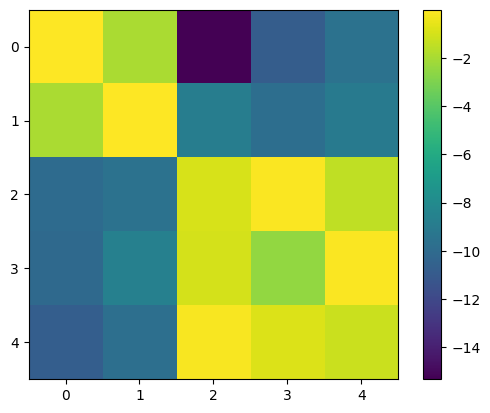

In [138]:
plt.imshow(results['eigenvectors'][0]['U'].abs().log())
plt.colorbar()

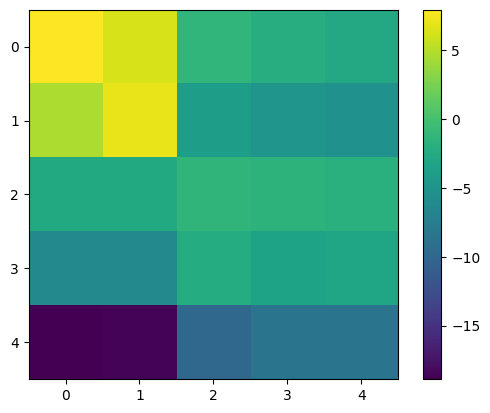

In [130]:
plt.imshow(results['pca_edges'][0][1].abs().log())
plt.colorbar()

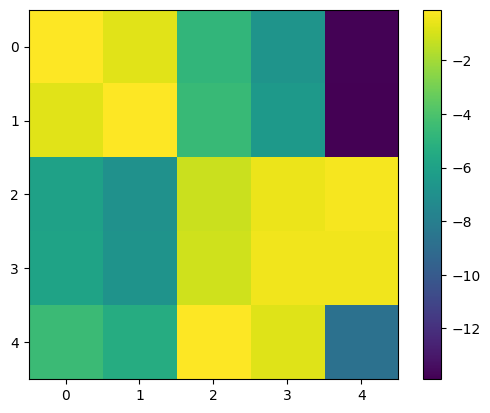

In [131]:
plt.imshow(results['interaction_rotations'][1]['C'].abs().log())
plt.colorbar()

tensor([15867.6445, 15817.4727,   317.8133,   316.7195,   314.3563])


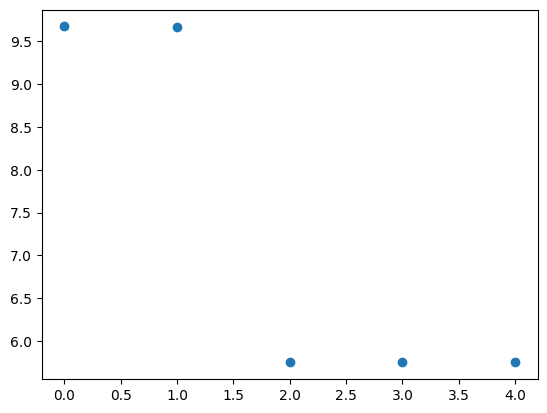

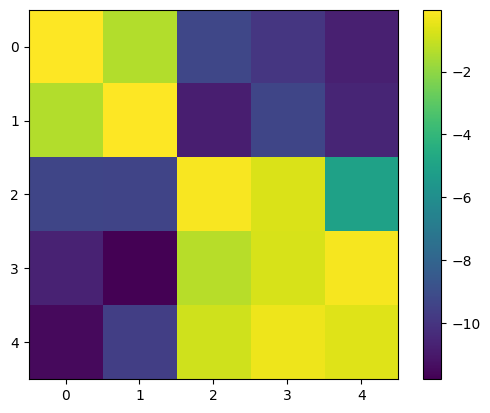

tensor([1.8292e+04, 1.1333e+04, 2.5019e+02, 1.3835e+02, 5.7133e+00])


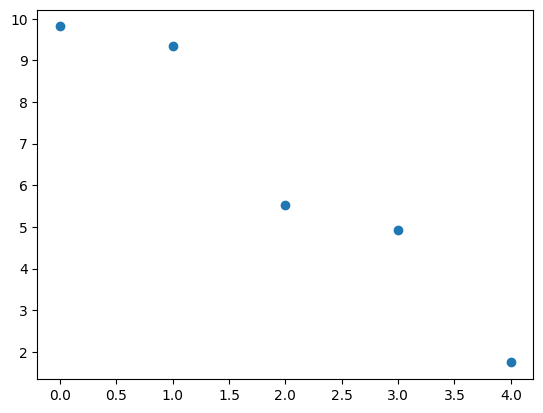

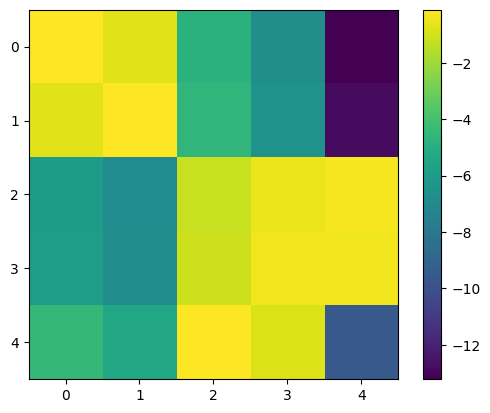

tensor([1.4446e+04, 1.0519e+04, 2.2988e+02, 1.8441e-01, 4.5020e-11])


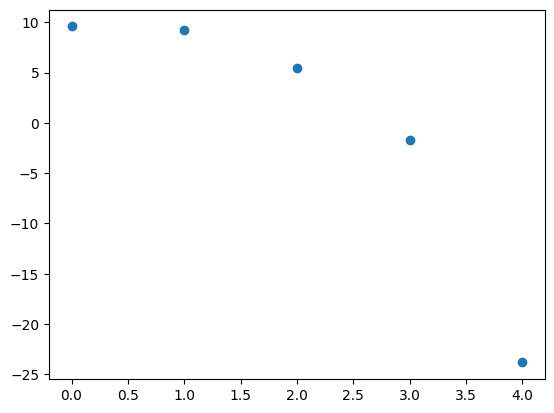

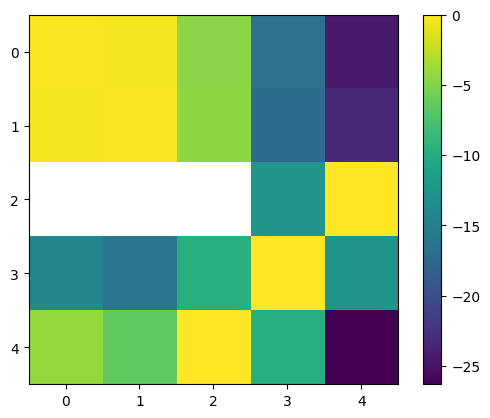

tensor([4.8738e+03, 2.7987e+02, 1.0965e+02, 1.0100e-01, 1.7689e-08])


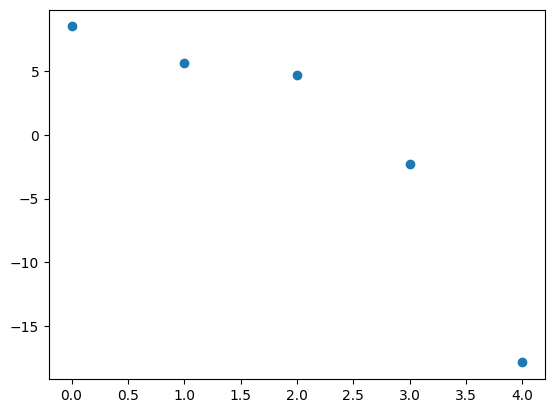

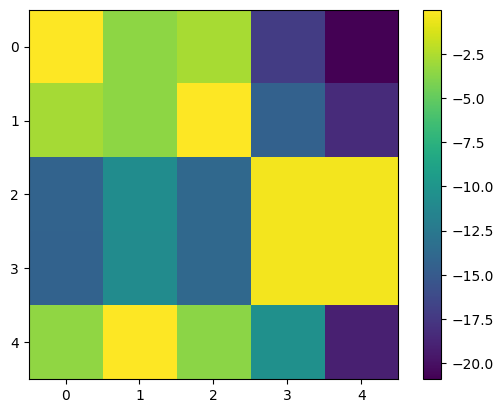

In [139]:
for i in range(4):
    U,S,Vt = torch.svd(activations[f'layers.{i}'])# - activations[f'layers.{i}'].mean(dim=0))
    print(S)
    plt.scatter(range(len(S)),S.log())
    plt.show()
    plt.imshow(Vt.abs().log())
    plt.colorbar()
    plt.show()